<h1>CS4618: Artificial Intelligence I</h1>
<h1>Training a Convolutional Neural Network</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.applications.resnet50 import decode_predictions

<h1>Acknowledgement</h1>
<ul>
    <li>This lecture, including the code, is based closely on sections 5.2 and 5.3 of: 
        Fran&ccedil;ois Chollet: <i>Deep Learning with Python</i>,
        Manning Publications, 2018
    </li>
    <li>The diagram is based closely on Figure 11-4 in: A. G&eacute;ron: 
        <i>Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (2nd edn)</i>, O'Reilly, 2019
    </li>
</ul>

<h1>Warning</h1>
<ul>
    <li>It will probably be impossible for you to run the code in this notebook in one go. Even on Google Colab, it may take an hour or so.
    </li>
</ul>

<h1>It's Raining Cats and Dogs</h1>
<ul>
    <li>THere is a dataset, supplied by Microsoft researchers, for a Kaggle competition:
        <a href="https://www.kaggle.com/c/dogs-vs-cats">https://www.kaggle.com/c/dogs-vs-cats</a>
        <ul>
            <li>12,500 medium-resolution JPEGs depicting cats and 12,500 depicting dogs.</li>
        </ul>
    </li>
    <li>We use a subset of the full dataset:
        <ul>
            <li>training set: 1000 cats and 1000 dogs;</li>
            <li>validation set: 500 cats and 500 dogs;</li>
            <li>test set: 500 cats and 500 dogs.</li>
        </ul>
    </li>
</ul>

In [4]:
base_dir = "../datasets/dataset_cats_and_dogs"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

<ul>
    <li>Let's look at one of the dogs:</li>
</ul>

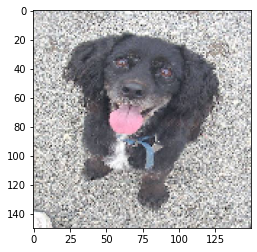

In [5]:
train_dogs_dir = os.path.join(train_dir, "dogs")
filenames = [os.path.join(train_dogs_dir, filename) for filename in os.listdir(train_dogs_dir)]

idx = 303 # Change this if you want to look at a different dog
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)

<h2>Data Preprocessing</h2>
<ul>
    <li>We must:
        <ul>
            <li>decode JPEGs to uncompressed grids of RGB pixels;</li>
            <li>convert the RGB values (integers in $[0, 255]$) to floats in $[0,1]$;
            </li>
            <li>resize images so they're all the same size, in our case $150 \times 150$;</li>
            <li>encode the class labels appropriately.</li>
        </ul>
    </li>
    <li>It's also better not to read the whole dataset into main memory.
        <ul>
            <li>We can process it in mini-batches and should read and convert batches on an as-needed basis.</li>
            <li>We'll use mini-batches of size 20.</li>
        </ul>
    </li>
    <li>In Keras, the <code>ImageDataGenerator</code> class does all this!
        <ul>
            <li>Its <code>flow_from_directory</code> function yields batches indefinitely, in an infinite loop.</li>
            <li>(It uses a Python generator.)</li>
        </ul>
    </li>
</ul>

In [6]:
train_data_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_data_generator.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=20, class_mode="binary")

val_data_generator = ImageDataGenerator(rescale=1./255)
val_generator = val_data_generator.flow_from_directory(
    val_dir, target_size=(150,150), batch_size=20, class_mode="binary")

test_data_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_directory(
    test_dir, target_size=(150,150), batch_size=20, class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<h2>Creating the ConvNet</h2>
<ul>
    <li>Since the images are bigger than the MNIST ones, we use a network with more layers
    </li>
</ul>

In [7]:
def build_convnet():
    network = Sequential()
    network.add(Conv2D(128, (3, 3), activation="relu", input_shape=(150, 150, 3)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(64, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(32, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(512, activation="relu"))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=SGD(lr=0.01), loss="binary_crossentropy", metrics=["accuracy"])
    return network

In [8]:
convnet = build_convnet()

In [9]:
convnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        1

<h2>Training and Testing</h2>
<ul>
    <li>Since the train generator and validation generator draw mini-batches indefinitely, we must specify 
        values for <code>steps_per_epoch</code> to make them terminate:
        <ul>
            <li>for the train generator, since we asked for mini-batches of size 20, an epoch that contans
                100 steps will cover all 2000 training examples;
            </li>
            <li>for the validation generator, with mini-batch size 20 again, 50 steps will cover all 1000 
                validation examples.
            </li>
        </ul>
    </li>
    <li>We'll use more epochs than before, but still with early stopping.</li>
    <li>Warning: might take some time!</li>
</ul>

In [10]:
convnet_history = convnet.fit(train_generator, steps_per_epoch=100, epochs=30, 
                validation_data=val_generator, validation_steps=50,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

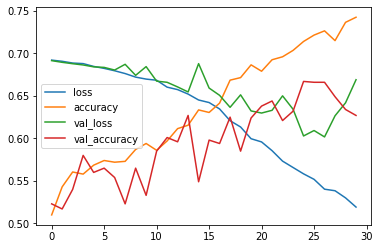

In [11]:
pd.DataFrame(convnet_history.history).plot()

<ul>
    <li>You would tweak and tune until you were happy with your model.</li>
</ul>

<h1>Data Augmentation</h1>
<ul>
    <li>With so few examples, overfitting is a major concern.</li>
    <li>We know all sorts of things we can try in order to reduce the overfitting.
        <ul>
            <li>We'll add a dropout layer below.</li>
        </ul>
    </li>
    <li>Another way to reduce overfitting is to get more examples but here we do something similar: 
        <b>data augmentation</b>.
        <ul>
            <li>We augment the training set with examples that we <em>synthesize</em> from the existing 
                training set.
            </li>
            <li>It's relatively easy when the dataset consists of images to use transformations
                on existing images to synthesize believable-looking new images.
            </li>
            <li>Be aware that this is not as good as additional real examples.
                <ul>
                    <li>These synthesized examples are correlated with each other and the originals
                        from which they were generated.
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>In Keras, the <code>ImageDataGenerator</code> can be configured to do this for us, and
        we will use the following ones here:
        <ul>
            <li><code>rotation_range</code>: degree range for random rotations;</li>
            <li><code>width_shift_range</code>: range for random horizontal shifts;</li>
            <li><code>height_shift_range</code>: range for random vertical shifts;</li>
            <li><code>shear_range</code>: shear angle in counter-clockwise direction as radians;</li>
            <li><code>zoom_range</code>: range for random zoom;</li>
            <li><code>horizontal_flip</code>: randomly, whether to flip inputs horizontally;</li>
            <li><code>fill_mode</code>: the strategy for filling-in newly created pixels that appear after
                some of the other transformations.
            </li>
        </ul>
    </li>
    <li>We only augment the training data generator, not the validation or test data generators</li>
</ul>

In [12]:
augmented_train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")
augmented_train_generator = augmented_train_data_generator.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=20, class_mode="binary")

Found 2000 images belonging to 2 classes.


<ul>
    <li>Out of curiosity, let's take the example image from earlier and see some of its
        transformations.
    </li>
</ul>

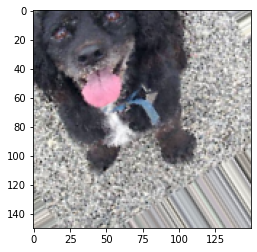

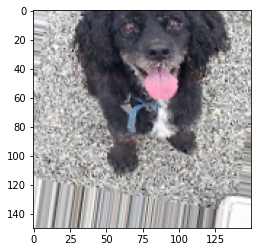

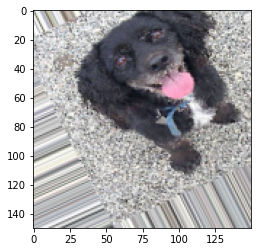

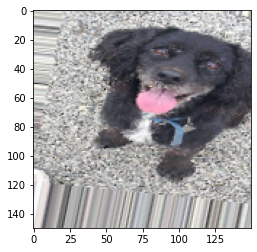

In [13]:
x = img_to_array(some_example)
x = x.reshape((1,) + x.shape)

i = 0
for batch in augmented_train_data_generator.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

<h2>Training with Data Augmentation</h2>

In [14]:
def build_convnet_with_dropout():
    network = Sequential()
    network.add(Conv2D(128, (3, 3), activation="relu", input_shape=(150, 150, 3)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(64, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(32, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dropout(0.5))
    network.add(Dense(512, activation="relu"))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=SGD(lr=0.01), loss="binary_crossentropy", metrics=["accuracy"])
    return network

In [15]:
dropout_convnet = build_convnet_with_dropout()

In [16]:
# Note we can run for more epochs

dropout_history = dropout_convnet.fit(augmented_train_generator, steps_per_epoch=100, epochs=60, 
                validation_data=val_generator, validation_steps=50,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

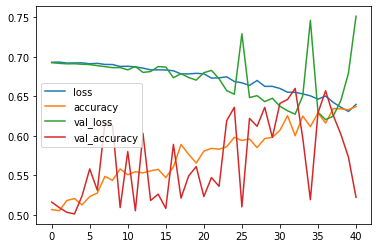

In [17]:
pd.DataFrame(dropout_history.history).plot()

<h2>Some predictions</h2>
<ul>
    <li>Let's read in some images, display them, turn them into a tensor and see what the model predicts for
        the images in this tensor
    </li>
</ul>

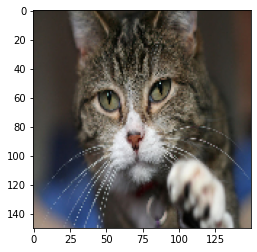

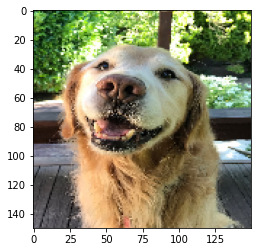

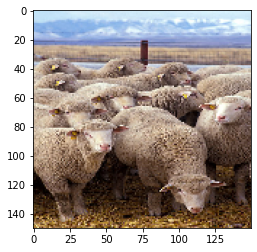

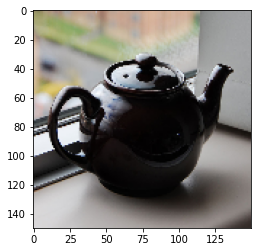

In [18]:
path = "../datasets/dataset_wikipedia_images"
pathnames = [os.path.join(path, filename) for filename in sorted(os.listdir(path))]

imgs = [load_img(img_path, target_size=(150, 150)) for img_path in pathnames]
for img in imgs:
    plt.figure()
    plt.imshow(img)

In [19]:
img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor /= 255

In [20]:
dropout_convnet.predict(img_tensor)

array([[0.43023312],
       [0.784829  ],
       [0.51160383],
       [0.5744415 ]], dtype=float32)

<h1>Pretrained Convolutional Neural Networks</h1>
<ul>
    <li>A <b>pretrained network</b> is a saved network that was trained, usually on a large dataset.</li>
    <li>Remarkably, these are increasingly being made available for image classification, speech
        recognition and other tasks.
    </li>
    <li>Consider the ImageNet dataset (<a href="http://www.image-net.org/">http://www.image-net.org/</a>):
        <ul>
            <li>1.4 million images, each manually labeled with one class per image;</li>
            <li>thousands of classes, mostly animals and everyday objects;</li>
            <li>annual competitions (ImageNet Large Scale Visual Recognition Challenges, ILSVRC), now
                hosted on Kaggle.
            </li>
        </ul>
    </li>
    <li>There are several pretrained neural networks for ImageNet, half a dozen of which are made
        available directly in Keras, including
        <ul>
            <li>VGG16 and VGG19;</li>
            <li>ResNet50 and ResNet101;</li>
            <li>Inception V3.</li>
        </ul>
    </li>
    <li>
        These networks incorporate a number of innovations, which we don't have time to study in depth,
        including
        local response normalization,
        <!-- where strongly activated neurons in one feature map can inhibit
             neurons in the same position in neighbouring feature maps, which encourages feature maps
             to specialize.
        -->
        skip connections,
        <!-- where the input into one layer is also added to the output of a layer a bit
             higher up the stack. This means that the later layer must in effect learn the difference 
             (residual) between what it would have learned and the amount that has been added. This
             boosts the signal across the network, which can encourage learning.
        -->
        inception modules, 
        <!-- where (roughly) there are multiple convolutions with different window
             sizes operating at the same level of the network, making the network wider rather than
             deeper. They help reduce dimensionality and result in networks with fewer parameters.
        -->
        and depthwise separable convolutional layers.
        <!-- where (roughly) there are convolutional layers
             whose neurons connect to only one feature map in the layer below (to detect spatial 
             patterns) and then regular convolutional layers (but with $1 \times 1$ windows) that look 
             for patterns between the feature maps of the spatial layer.
        -->
        Every year sees further innovations. Many are trying to find better ways of learning how objects
        are composed of smaller parts; for one example, see capsules.
    </li>
    <li>In this lecture, we'll see how to use a pretrained network (ResNet50) for <b>transfer learning</b>:
        using it as the lower layers of our own network.
    </li>
</ul>

<h1>ResNet50</h1>
<ul>
    <li>Compare its base with the full network.</li>
</ul>

In [21]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 5s 0us/step


In [22]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
resnet50 = ResNet50(weights="imagenet", include_top=True)

102973440/102967424 [==============================] - 3s 0us/step


In [24]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

<ul>
    <li>Let's see what ResNet50 predicts 
        for the four images from earlier.
    </li>
</ul>

In [25]:
# Read them again so that we can scale them differently
imgs = [load_img(img_path, target_size=(224, 224)) for img_path in pathnames]
img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor = preprocess_input(img_tensor)

# Predict
preds = resnet50.predict(img_tensor)
decoded_preds = decode_predictions(preds, top=3)
for dp in decoded_preds:
    print("Predicted: ", dp, "\n")

40960/35363 [==================================] - 0s 0us/step
Predicted:  [('n02123159', 'tiger_cat', 0.41495466), ('n02124075', 'Egyptian_cat', 0.28725174), ('n02123045', 'tabby', 0.27097523)] 

Predicted:  [('n02099601', 'golden_retriever', 0.54349613), ('n02099712', 'Labrador_retriever', 0.29421175), ('n02099849', 'Chesapeake_Bay_retriever', 0.08250172)] 

Predicted:  [('n02396427', 'wild_boar', 0.40471083), ('n02412080', 'ram', 0.39849755), ('n02137549', 'mongoose', 0.1221533)] 

Predicted:  [('n04398044', 'teapot', 0.999049), ('n03063689', 'coffeepot', 0.00093858276), ('n04560804', 'water_jug', 5.9944414e-06)] 



<h1>Transfer Learning</h1>
<ul>
    <li><b>Transfer learning</b>:
        <ul>
            <li>taking a model that was learned when solving one problem and <em>re-using</em> it for solving
                a different but related problem.
            </li>
        </ul>
    </li>
    <li>Advantages:
        <ul>
            <li>it speeds-up training for the new problem;</li>
            <li>it means that less training data may be needed for the new problem.</li>
        </ul>
    </li>
    <li>Deep neural networks are more amenable to transfer learning than many other machine learning
        techniques:
        <ul>
            <li>take a pre-trained network;</li>
            <li>re-use its lower layers, even <b>freezing</b> their weights.</li>
        </ul>
        <figure>
            <img src="images/transfer.png" />
        </figure>
    </li>
    <li>E.g.
        <ul>
            <li>We have several networks that are pre-trained on ImageNet, including ResNet50:
                <ul>
                    <li>trained to classify images into 1000 classes (various animals, vehicles, etc.).</li>
                </ul>
            </li>
            <li>We can re-use the lower layers in a new network that is trained to classify images 
                of just cats and dogs, or different types of vehicles, or for face recognition, or
                perhaps even facial expression recognition.
            </li>
        </ul>
    </li>
    <li>Of course, this will only work well if the original and new tasks share similar low-level features.
        <ul>
            <li>The more similar the new problem is to the original problem, the more layers we may want to
                re-use.
            </li>
        </ul>
    </li>
</ul> 

<h2>Re-using the Convolutional Base of a Pretrained ConvNet</h2>
<ul>
    <li>Convolutional Neural Networks typically comprise two parts:
        <ul>
            <li>the <b>convolutional base</b>: the convolutional and pooling layers;</li>
            <li>the densely-connected top layers for, e.g. classification.</li>
        </ul>
    </li>
    <li>We want to reuse the convolutional base:
        <ul>
            <li>the features learned by these layers are likely to be more generic;</li>
            <li>the features learned by the top layers will be more specific to the original task.</li>
        </ul>
    </li>
</ul>

<h2>It's Raining Cats and Dogs, again</h2>
<ul>
    <li>We'll re-use the convolutional base of the ResNet50 model within a new network for
        classifying cats and dogs.
    </li>
    <li>We create our new network but we add the pre-trained convolutional base of the ResNet50 model, 
        just as we would add a layer.
    </li>
    <li>Note how we <b>feeze</b> the weights in the layers of the convolutional base. If we did not, 
        then the features that were learned previously would be lost.
    </li>
</ul>

In [26]:
def build_network_with_transfer_learning():
    network = Sequential()
    network.add(resnet50_base);
    resnet50_base.trainable = False
    network.add(Flatten())
    network.add(Dropout(0.5))
    network.add(Dense(256, activation="relu"))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=SGD(lr=0.01), loss="binary_crossentropy", metrics=["accuracy"])
    return network

In [27]:
transfer_learning_network = build_network_with_transfer_learning()

In [28]:
transfer_learning_network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________________________________


In [29]:
augmented_train_data_generator_for_resnet = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")
augmented_train_generator_for_resnet = augmented_train_data_generator_for_resnet.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=20, class_mode="binary")

val_data_generator_for_resnet = ImageDataGenerator(rescale=1./255)
val_generator_for_resnet = val_data_generator_for_resnet.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=20, class_mode="binary")

test_data_generator_for_resnet = ImageDataGenerator(rescale=1./255)
test_generator_for_resnet = test_data_generator_for_resnet.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=20, class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [30]:
transfer_learning_history = transfer_learning_network.fit(
                augmented_train_generator_for_resnet, steps_per_epoch=100, epochs=60, 
                validation_data=val_generator_for_resnet, validation_steps=50,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

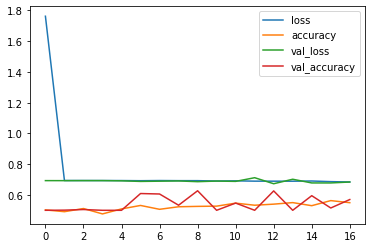

In [31]:
pd.DataFrame(transfer_learning_history.history).plot()

<h2>Unfreezing Parts of the Convolutonal Base</h2>
<ul>
    <li>Now that our new top layesr are well-trained, we can unfreeze all layers in the base (or just the
        top ones in the base) and contnue training.
    </li>
    <li>You probably want a lower learning rate to avoid damaging the pretrained weights.
        <ul>
            <li>One could even imagine different learning rates for different layers:
                smaller ones at the bottom of the base than at the top of the base.
            </li>
        </ul>
    </li>
    <li>In Keras, re-compilation is needed at this point.</li>
</ul>

In [32]:
resnet50_base.trainable = True

In [33]:
transfer_learning_network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 49,278,337
Trainable params: 49,225,217
Non-trainable params: 53,120
_________________________________________________________________


In [34]:
transfer_learning_network.compile(optimizer=SGD(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [35]:
tuned_history = transfer_learning_network.fit(
                augmented_train_generator_for_resnet, steps_per_epoch=100, epochs=60, 
                validation_data=val_generator_for_resnet, validation_steps=50,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

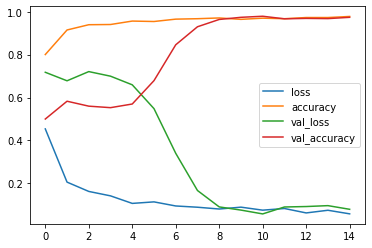

In [36]:
pd.DataFrame(tuned_history.history).plot()

<h1>Testing</h1>
<ul>
    <li>Let's test them all on the test set.</li>
</ul>

In [37]:
# The original convnet
test_loss, test_acc = convnet.evaluate(test_generator)
test_acc

50/50 [==============================] - 487s 10s/step - loss: 0.6786 - accuracy: 0.6280


0.628000020980835

In [38]:
# The convnet with dropout, trained using data augmentation
test_loss, test_acc = dropout_convnet.evaluate(test_generator)
test_acc

50/50 [==============================] - 4s 71ms/step - loss: 0.6400 - accuracy: 0.6180


0.6179999709129333

In [39]:
# The convnet that was trained and tuned using transfer learning
test_loss, test_acc = transfer_learning_network.evaluate(test_generator_for_resnet)
test_acc

50/50 [==============================] - 5s 91ms/step - loss: 0.0670 - accuracy: 0.9660


0.9660000205039978

<h1>Saving and Restoring Models</h1>
<ul>
    <li>Having learned the weights, we should save a model so that we don't have to learn them again!</li>
    <li><code>save</code> is a method that saves a Keras model (network, weights, training configuration,
        state of the optimizer) into a HDF5 file.
    </li>
    <li><code>load_model</code>: reinstantiates the model, including compiling the model using the saved 
        training configuration.
    </li>
</ul>

In [ ]:
dropout_convnet.save("models/my_model.h5")

In [ ]:
reloaded_convnet = load_model("models/my_model.h5")

<h1>Concluding Remarks</h1>
<ul>
    <li>It's often said that we need lots of data for deep learning.</li>
    <li>But transfer learning helps us in cases where we have more limited data.</li>
    <li>E.g. we want to do face recognition but we have only a few pictures of each person,
        not enought to train a good classifier:
        <ul>
            <li>Collect loads of pictures of faces of random people from the web.</li>
            <li>Train a network to detect whether or not two different pictures portray the same person.</li>
            <li>This network is presumably a good feature detector for faces.</li>
            <li>Use this network as the lower layers of your face recognition classifier.</li>
        </ul>
    </li>
    <li>E.g. we want to do some natural language processing but we don't have a large dataset.
        <ul>
            <li>Collect loads of sentences from the web, label them 'good'.</li>
            <li>Corrupt these sentences in various ways, and label them 'bad'.</li>
            <li>Train a network to classify sentences and non-sentences ('good' vs. 'bad').</li>
            <li>Use this network as the lower layers of your natural language processing system.</li>
        </ul>
    </li>
</ul>